<p style="text-align: center;"> <span style="color:firebrick"> <font size="5"> <b> USC Marshall School of Business </b> </font> </p> </span> 

<p style="text-align: center;"> <b> <font font size="5"> DSO 562 - Application Fraud Prediction Project</p> </b></font>

<p style="text-align: center;"> <b> Spring 2022 </b> </p>

## <span style="color:black"> <font size="3">By: Ningchuan Peng</span>
    
## <span style="color:black"> <font size="3">Date: 2022/3/26</span>

In this project, I will conduct the application fraud prediction based on synethitic application data name `applications data.csv`.

The dataset has 1,000,000 observations with the following attributes:
- `record`: the identifier of each observation
- `date`: the date of the application
- `ssn`: the ssn number of the applicant
- `firstname`: the firstname of the applicant
- `lastname`: the lastname of the applicant
- `address`: the address of the applicant
- `zip5`: the 5-digit zip code of the applicant
- `dob`: the date of birth of the applicant
- `homephone`: the phone number of the applicant's home
- `fraud_label`: whether the observation is fraud (1) or not (0)

The main process of the fraud prediction:
1. Data Quality Review: inspect the attributes of the dataset
2. Feature Engineering: data cleaning and build new features
3. Feature Selection: select the top 30 features for further model building
4. Model Building and Evaluation: run different models to do the prediction

For model evaluation, I will use fraud detection rate at 3% to assess the effectiveness of the model.

In [1]:
# load libararies
import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime
import calendar
import time
start_time = datetime.now()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.rcParams.update({'figure.figsize':(12,6)})
plt.rcParams.update({'font.size':20})

import scipy.stats as sps
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

print('load duration: ', datetime.now() - start_time)

load duration:  0:00:01.532120


In [2]:
# read the data
data = pd.read_csv("applications data.csv")

# Data Quality Review

In [3]:
# show the data
data.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20160101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20160101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20160101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20160101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20160101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


In [4]:
# change the date data type
data['date'] = pd.to_datetime(data['date'], format="%Y%m%d")

In [5]:
# describe the data
data.describe()

,record,ssn,zip5,dob,homephone,fraud_label
count,1000000.000000,1.000000e+06,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000
mean,500000.500000,5.083415e+08,50073.333143,1.951725e+07,5.368716e+09,0.014393
std,288675.278933,2.934864e+08,28915.921546,3.568872e+05,3.082161e+09,0.119104
min,1.000000,3.600000e+01,2.000000,1.900010e+07,5.937990e+05,0.000000
25%,250000.750000,2.542176e+08,24992.000000,1.916092e+07,2.677134e+09,0.000000
50%,500000.500000,5.088144e+08,50492.000000,1.950090e+07,5.399910e+09,0.000000
75%,750000.250000,7.630924e+08,74496.000000,1.983032e+07,8.109241e+09,0.000000
max,1000000.000000,1.000000e+09,99999.000000,2.016103e+07,1.000000e+10,1.000000


## date

<AxesSubplot:title={'center':'Daily Applications'}, xlabel='date'>

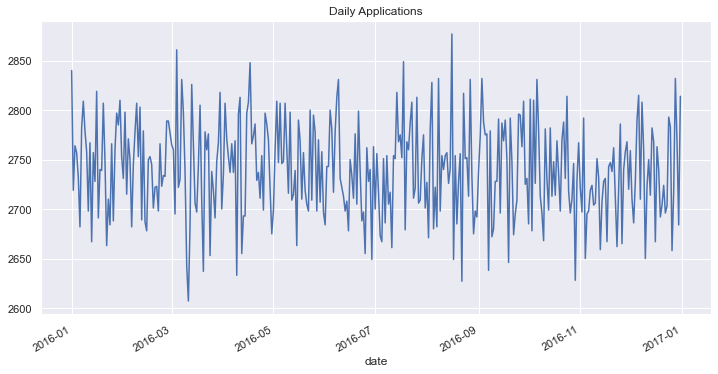

In [6]:
# the 2016-02-29 has no data
daily_count = data[['date', 'record']].groupby('date').count()['record']
daily_count.plot(title = 'Daily Applications')

<AxesSubplot:title={'center':'Weekly Applications'}, xlabel='week'>

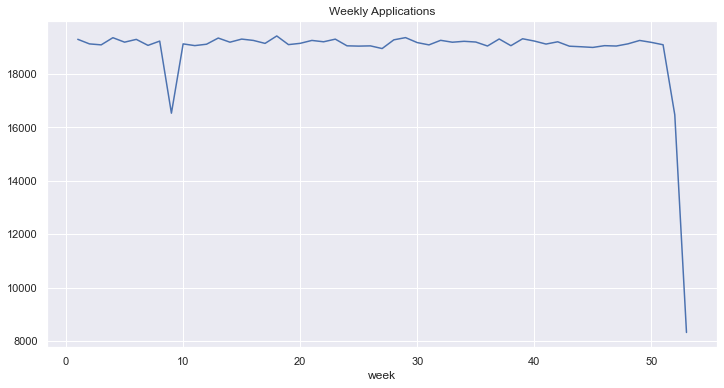

In [7]:
# review the data from weekday perspective
data['week'] = data['date'].dt.isocalendar().week
weekly_count = data[['week', 'record']].groupby('week').count()['record']
data = data.drop(['week'], axis=1)
weekly_count.plot(title = 'Weekly Applications')

## SSN

<AxesSubplot:>

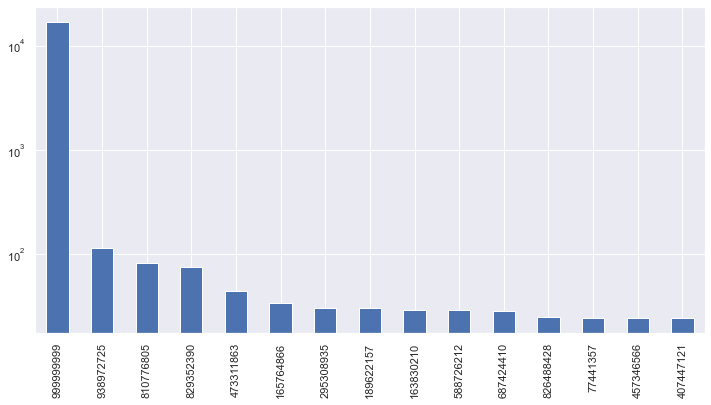

In [8]:
# count the most SSN number
data['ssn'].value_counts().head(15).plot(kind='bar',logy=True)

In [9]:
# show the observation with ssn=999999999
data[data['ssn'] == 999999999].head(10)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
10,11,2016-01-01,999999999,UZZSMXSEE,USJZUSA,726 UMTXU ST,92129,19400126,3026547212,0
22,23,2016-01-01,999999999,ETXMUSZEM,UJMAMEU,3387 STRUM WY,45982,19580830,5568704443,0
64,65,2016-01-01,999999999,STUMMAMTS,SSJXTUJM,6393 UEJEA LN,41640,19070626,9999999999,0
68,69,2016-01-01,999999999,UUZAJXZMT,SRAAMZXU,2557 URRXS DR,98407,20110831,5490098836,0
74,75,2016-01-01,999999999,AUATMMZX,UUUTAZR,30 ETXRM ST,38402,19760625,2382673773,0
283,284,2016-01-01,999999999,MSJUZSMZJ,UXMTEZUT,356 UZSRE AVE,74187,19070626,153492955,0
380,381,2016-01-01,999999999,XRJSMRRRT,RMRXAMX,9769 UAMZJ DR,52351,19070626,3181686949,0
420,421,2016-01-01,999999999,XRXMTMZEZ,SZRXXJMX,5854 RXRXX PL,34957,19970721,316681200,0
446,447,2016-01-01,999999999,RRZUZUSX,ESZRRRAA,8970 AXME RD,48333,19110729,5350782211,0
468,469,2016-01-01,999999999,XETRJXESR,SSJXTUJM,6995 RMSST CT,48162,19700418,2503172355,0


## firstname & lastname

<AxesSubplot:>

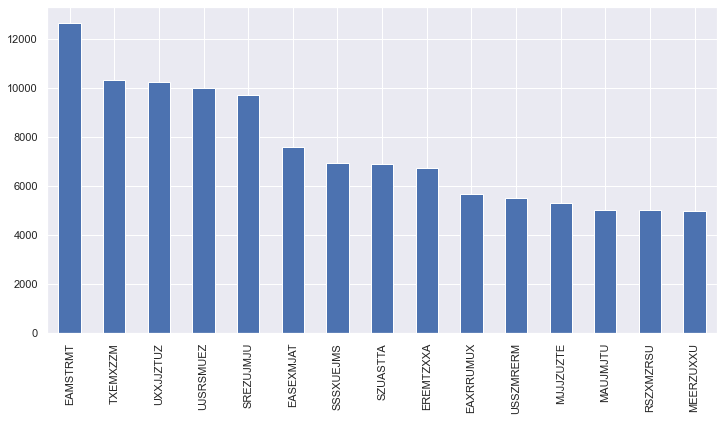

In [10]:
# count the most firstname
data['firstname'].value_counts().head(15).plot(kind = 'bar')

<AxesSubplot:>

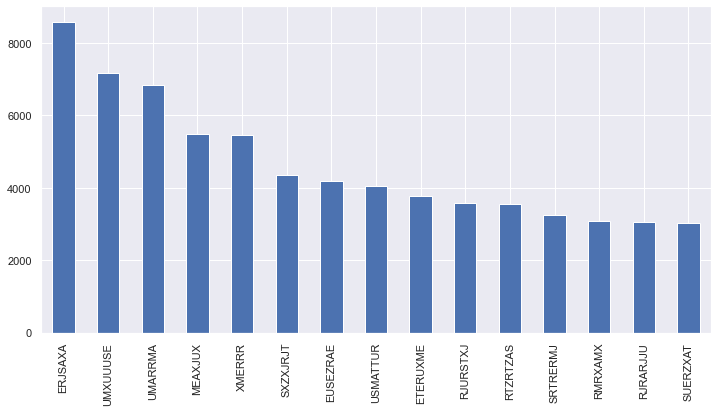

In [11]:
# count the most lastname
data['lastname'].value_counts().head(15).plot(kind = 'bar')

## address & zip5 & dob & homephone

<AxesSubplot:>

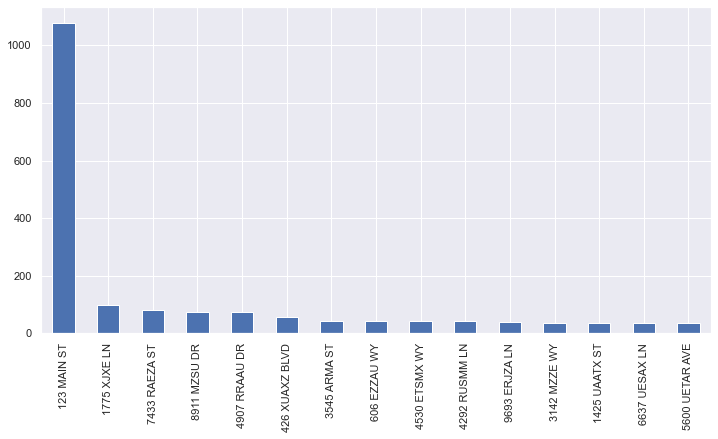

In [12]:
# count the most address
data['address'].value_counts().head(15).plot(kind = 'bar')

In [13]:
# show the observation with address= '123 MAIN ST'
data[data['address'] == '123 MAIN ST'].head(10)

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
1247,1248,2016-01-01,904524264,UJSRSMUEZ,EAXAXAXA,123 MAIN ST,68138,19241031,8135264540,0
2191,2192,2016-01-01,345413970,XXSMUSEJT,SRRAXESJ,123 MAIN ST,68138,19300526,94097353,0
2529,2530,2016-01-01,821839005,UXZUMTRTR,EARTMRJS,123 MAIN ST,68138,19621101,7715547340,0
3434,3435,2016-01-02,24205988,SXTUZZXAS,UJJAJMM,123 MAIN ST,68138,19640428,8788942828,0
3750,3751,2016-01-02,623763056,SEZESJMSR,UZJEUZMT,123 MAIN ST,68138,19731107,974228226,0
4715,4716,2016-01-02,686787130,SXXSZJMM,ARRZTAA,123 MAIN ST,68138,19810323,1839236819,1
5353,5354,2016-01-02,932938215,UXRJESTM,EETAEAR,123 MAIN ST,68138,19980513,5441682419,0
7299,7300,2016-01-03,417080344,SJETUJAAZ,REMJTREU,123 MAIN ST,92821,19340914,7507186577,0
8512,8513,2016-01-04,477797652,EAMSTRMT,UTXXZZET,123 MAIN ST,68138,19190519,5922864904,0
8750,8751,2016-01-04,6367698,XUERJXSTU,EERMEXAE,123 MAIN ST,42035,19821127,6442565981,0


<AxesSubplot:>

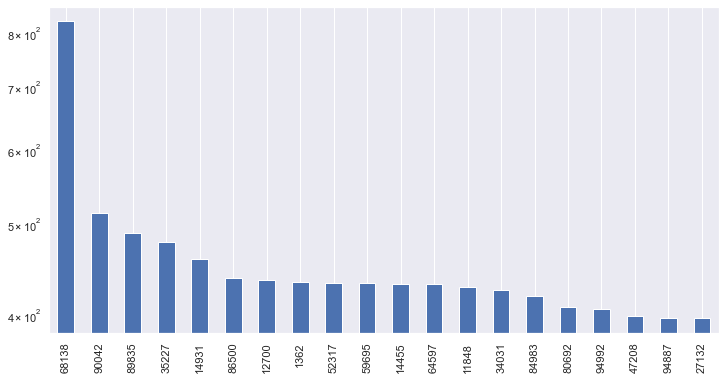

In [14]:
# count the most zip5
data['zip5'].value_counts().head(20).plot(kind='bar',logy=True)

<AxesSubplot:>

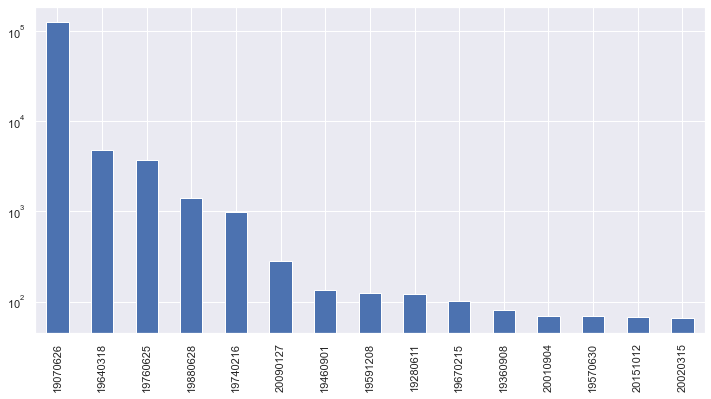

In [15]:
# count the most dob
data['dob'].value_counts().head(15).plot(kind='bar',logy=True)

<AxesSubplot:>

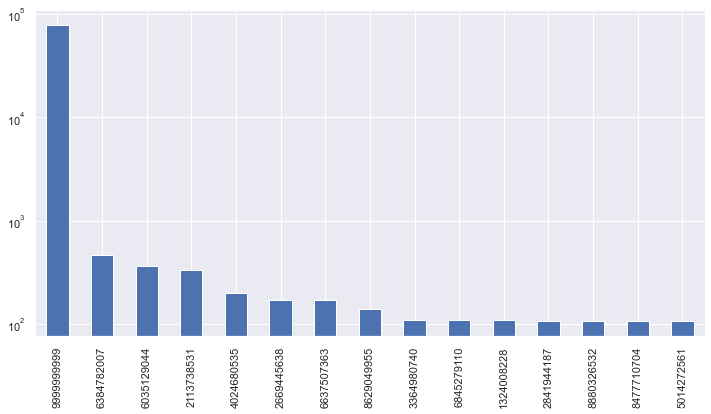

In [16]:
# count the most homephone
data['homephone'].value_counts().head(15).plot(kind='bar',logy=True)

# Feature Engineering

## data cleaning

In [17]:
# add 0 for empty zip
data['zip5'] = data['zip5'].apply (lambda x:'{0:0>5}'.format(x))

#fix frivolous values - ssn
data.loc[data.ssn == 999999999, 'ssn'] = -data[data.ssn == 999999999]['record']
data['ssn'] = data['ssn'].apply (lambda x:'{0:0>9}'.format(x))

#fix frivolous values - address
data.loc[data.address == '123 MAIN ST', 'address'] = data.loc[data.address == '123 MAIN ST', 'record'].\
apply(lambda x: str(x) +' RECORD')

#fix frivolous values - dob
data.loc[data.dob == 19070626, 'dob'] = -data[data.dob == 19070626]['record']
data['dob'] = data['dob'].apply (lambda x:'{0:0>8}'.format(x))

#fix frivolous values - homephone
data.loc[data.homephone == 9999999999, 'homephone'] = -data[data.homephone == 9999999999]['record']
data['homephone'] = data['homephone'].apply (lambda x:'{0:0>10}'.format(x))

In [18]:
# show the data after data cleaning
data.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0


In [19]:
# show the data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   record       1000000 non-null  int64         
 1   date         1000000 non-null  datetime64[ns]
 2   ssn          1000000 non-null  object        
 3   firstname    1000000 non-null  object        
 4   lastname     1000000 non-null  object        
 5   address      1000000 non-null  object        
 6   zip5         1000000 non-null  object        
 7   dob          1000000 non-null  object        
 8   homephone    1000000 non-null  object        
 9   fraud_label  1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 76.3+ MB


## Make day of week target encoding

In [20]:
data['dow']= data.date.apply(lambda x: calendar.day_name[x.weekday()])
train_test = data[data.date<'2016-11-01']

In [21]:
# statistical smoothing
c = 4; nmid = 20; y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg) / (1 + np.exp(-(num-nmid)/c))
data['dow_risk'] = data.dow.map(y_dow_smooth)

In [22]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow = pd.DataFrame(y_dow).reindex(index = cats)
y_dow

,fraud_label
dow,
Monday,0.013480
Tuesday,0.014070
Wednesday,0.015169
Thursday,0.014981
Friday,0.014499
Saturday,0.014968
Sunday,0.013674


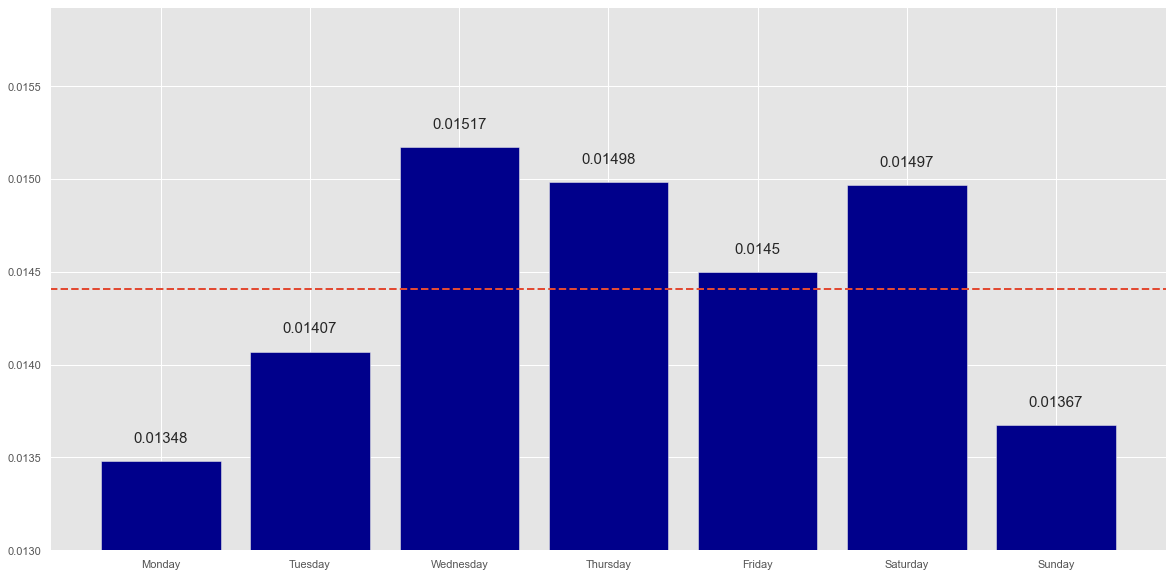

In [23]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=y_dow, x=y_dow.index, height='fraud_label', color='darkblue')
ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg, ls='--', lw=2)

for i, v in enumerate(y_dow.index):
    ax.text(v, y_dow.loc[v, 'fraud_label']+0.0001, 
            round(y_dow.loc[v, 'fraud_label'],5),
            horizontalalignment= 'center', 
            fontsize=15)
plt.show()

## Make Some New Entities for Variables

In [24]:
data['name'] = data.firstname + data.lastname
data['fulladdress'] = data.address + data.zip5
data['name_dob'] = data.name + data.dob
data['name_fulladdress'] = data.name + data.fulladdress
data['name_homephone'] = data.name + data.homephone
data['fulladdress_dob'] = data.fulladdress + data.dob
data['fulladdress_homephone'] = data.fulladdress + data.homephone
data['dob_homephone'] = data.dob + data.homephone
data['homephone_name_dob' ] = data.homephone + data.name_dob

data.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'name',
       'fulladdress', 'name_dob', 'name_fulladdress', 'name_homephone',
       'fulladdress_dob', 'fulladdress_homephone', 'dob_homephone',
       'homephone_name_dob'],
      dtype='object')

In [25]:
for field in list(data.iloc[:, np.r_[3:9, 12:15]].columns):
    print(field)

firstname
lastname
address
zip5
dob
homephone
name
fulladdress
name_dob


In [26]:
for field in list(data.iloc[:, np.r_[3:9, 12:15]].columns):
    data['ssn_' + field] = data.ssn + data[field]

data.columns

Index(['record', 'date', 'ssn', 'firstname', 'lastname', 'address', 'zip5',
       'dob', 'homephone', 'fraud_label', 'dow', 'dow_risk', 'name',
       'fulladdress', 'name_dob', 'name_fulladdress', 'name_homephone',
       'fulladdress_dob', 'fulladdress_homephone', 'dob_homephone',
       'homephone_name_dob', 'ssn_firstname', 'ssn_lastname', 'ssn_address',
       'ssn_zip5', 'ssn_dob', 'ssn_homephone', 'ssn_name', 'ssn_fulladdress',
       'ssn_name_dob'],
      dtype='object')

In [27]:
attributes = list(data.iloc[:, np.r_[2, 5, 7, 8, 12:30]].columns)

attributes

['ssn',
 'address',
 'dob',
 'homephone',
 'name',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladdress_dob',
 'fulladdress_homephone',
 'dob_homephone',
 'homephone_name_dob',
 'ssn_firstname',
 'ssn_lastname',
 'ssn_address',
 'ssn_zip5',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob']

## Make Some Variables - 1

In [28]:
df1 = data.copy()
vars = data.copy()
df1['check_date']= df1.date
df1['check_record']= df1.record
vars.shape

(1000000, 30)

In [29]:
# Velocity/counts and days since
begin = time.time()

for entity in attributes:
    st = time.time()
    df_1 = df1[['record', 'date', entity]]
    df_r = df1[['check_record', 'check_date', entity]]
    temp = pd.merge(df_1, df_r, left_on = entity, right_on = entity) # merge on the same value of entity
    
    # day since the same value appears again
    day_since_df = temp[temp.record > temp.check_record][['record', 'date', 'check_date']].\
    groupby('record')[['date', 'check_date']].last()
    mapper = (day_since_df.date - day_since_df.check_date).dt.days
    vars[entity + '_day_since'] = vars.record.map(mapper)
    vars[entity + '_day_since'].fillna(365, inplace=True)
    print(f'\n{entity}_day_since ---> Done')

    # velocity days larger than the time
    for offset_t in [0, 1, 3, 7, 14, 30]:
        count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t))) &
                            (temp.record >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        vars[col_name] = vars.record.map(mapper2)
        
        print (f'{entity}_count_{str(offset_t)} ---> Done')

    print(f'Run time for entity {entity} ------------ {time.time() - st}s')

print(f'Total run time: {(time.time() - begin) / 60} min')


ssn_day_since ---> Done
ssn_count_0 ---> Done
ssn_count_1 ---> Done
ssn_count_3 ---> Done
ssn_count_7 ---> Done
ssn_count_14 ---> Done
ssn_count_30 ---> Done
Run time for entity ssn ------------ 2.2260854244232178s

address_day_since ---> Done
address_count_0 ---> Done
address_count_1 ---> Done
address_count_3 ---> Done
address_count_7 ---> Done
address_count_14 ---> Done
address_count_30 ---> Done
Run time for entity address ------------ 2.1512317657470703s

dob_day_since ---> Done
dob_count_0 ---> Done
dob_count_1 ---> Done
dob_count_3 ---> Done
dob_count_7 ---> Done
dob_count_14 ---> Done
dob_count_30 ---> Done
Run time for entity dob ------------ 12.688223838806152s

homephone_day_since ---> Done
homephone_count_0 ---> Done
homephone_count_1 ---> Done
homephone_count_3 ---> Done
homephone_count_7 ---> Done
homephone_count_14 ---> Done
homephone_count_30 ---> Done
Run time for entity homephone ------------ 10.67648196220398s

name_day_since ---> Done
name_count_0 ---> Done
name_cou

In [30]:
#relative velocity
start = time.time()

for att in attributes:
    for d in ['0', '1']:
        for dd in ['3', '7', '14', '30']:
            vars[att + '_count_' + d + '_by_' + dd]  = \
            vars[att + '_count_' + d] / (vars[att + '_count_' + dd] / float(dd))

print(f'Total run time: {time.time() - start}s')

Total run time: 1.1299827098846436s


## Make Some Variables - 2

In [31]:
remove_list = ['address', 'dob', 'name', 'ssn_address', 'homephone', 'name_homephone', 'fulladdress_homephone',
               'homephone_name_dob', 'ssn_homephone', 'ssn_firstname', 'ssn_dob']

for remove_factor in remove_list:
    attributes.remove(remove_factor)

attributes

['ssn',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'fulladdress_dob',
 'dob_homephone',
 'ssn_lastname',
 'ssn_zip5',
 'ssn_name',
 'ssn_fulladdress',
 'ssn_name_dob']

In [32]:
begin = time.time()

for entity in attributes:
    for field in attributes:
        st = time.time()
        if field == entity:
            continue
        else:
            df_c = df1[['record', 'date', entity]]
            df_d = df1[['check_record', 'check_date', entity, field]]
            temp = pd.merge(df_c, df_d, left_on=entity, right_on=entity)

        # number of unique for particular field
        for offset_t in [1, 3, 7, 14, 30, 60]:
            count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t))) &
                                (temp.record >= temp.check_record)]
            col_name = f'{entity}_unique_count_for_{field}_{offset_t}'
            mapper = count_day_df.groupby(['record'])[field].nunique()
            vars[col_name] = vars.record.map(mapper)
        
        print(f'Run time for entity {entity} in field {field} ------------ {time.time() - st}s')

    print(f'Sub Total run time: {(time.time() - begin) / 60} min')

Run time for entity ssn in field fulladdress ------------ 3.87790846824646s
Run time for entity ssn in field name_dob ------------ 3.876645803451538s
Run time for entity ssn in field name_fulladdress ------------ 4.021259784698486s
Run time for entity ssn in field fulladdress_dob ------------ 3.886619806289673s
Run time for entity ssn in field dob_homephone ------------ 3.83874773979187s
Run time for entity ssn in field ssn_lastname ------------ 3.868664264678955s
Run time for entity ssn in field ssn_zip5 ------------ 3.7749783992767334s
Run time for entity ssn in field ssn_name ------------ 3.8586843013763428s
Run time for entity ssn in field ssn_fulladdress ------------ 3.989161252975464s
Run time for entity ssn in field ssn_name_dob ------------ 3.978426694869995s
Sub Total run time: 0.6495348930358886 min
Run time for entity fulladdress in field ssn ------------ 3.8347597122192383s
Run time for entity fulladdress in field name_dob ------------ 4.0242509841918945s
Run time for entit

Run time for entity ssn_fulladdress in field name_fulladdress ------------ 3.912551164627075s
Run time for entity ssn_fulladdress in field fulladdress_dob ------------ 3.8068604469299316s
Run time for entity ssn_fulladdress in field dob_homephone ------------ 3.7180445194244385s
Run time for entity ssn_fulladdress in field ssn_lastname ------------ 3.688145637512207s
Run time for entity ssn_fulladdress in field ssn_zip5 ------------ 3.5764482021331787s
Run time for entity ssn_fulladdress in field ssn_name ------------ 3.7962701320648193s
Run time for entity ssn_fulladdress in field ssn_name_dob ------------ 3.9265122413635254s
Sub Total run time: 6.378148818016053 min
Run time for entity ssn_name_dob in field ssn ------------ 3.659224510192871s
Run time for entity ssn_name_dob in field fulladdress ------------ 3.826782464981079s
Run time for entity ssn_name_dob in field name_dob ------------ 3.8068296909332275s
Run time for entity ssn_name_dob in field name_fulladdress ------------ 4.0

## Make Some Variables - 3

In [33]:
# Maximum Indicator (may not be useful for this project)
# begin=time.time()
# for i in attributes:
#     for v in ['3', '7', '30']:
#         st = time.time()
#         mapper = vars.groupby(i)[i+ '_count_'+ v].max( )
#         vars['max_count_by'+i+'_'+v]=vars[i].map(mapper)
#         print(f'max_count_by_{i}_{v} --->Done')
#     print(f'Run time for entity {i}------------{time.time()-st}s')
# print(f'Total run time:{(time.time()-begin)/60}min')

In [34]:
# show the dataset after feature engineering
vars.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,...,ssn_name_dob_unique_count_for_ssn_name_7,ssn_name_dob_unique_count_for_ssn_name_14,ssn_name_dob_unique_count_for_ssn_name_30,ssn_name_dob_unique_count_for_ssn_name_60,ssn_name_dob_unique_count_for_ssn_fulladdress_1,ssn_name_dob_unique_count_for_ssn_fulladdress_3,ssn_name_dob_unique_count_for_ssn_fulladdress_7,ssn_name_dob_unique_count_for_ssn_fulladdress_14,ssn_name_dob_unique_count_for_ssn_fulladdress_30,ssn_name_dob_unique_count_for_ssn_fulladdress_60
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,02765,000000-1,1797504115,0,...,1,1,1,1,1,1,1,1,1,1
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,...,1,1,1,1,1,1,1,1,1,1
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0,...,1,1,1,1,1,1,1,1,1,1
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0,...,1,1,1,1,1,1,1,1,1,1
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,03173,19980315,6101082272,0,...,1,1,1,1,1,1,1,1,1,1


# Feature Selection

In [35]:
# create the dataset for feature selection
df_total = vars.copy()
del vars

In [36]:
# set some parameters
num_files = 3
num_filter = 90
num_wrapper = 30
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

In [37]:
goods = df_total[df_total[y_name] == good_label]
bads = df_total[df_total[y_name] == bad_label]
#num_vars = len(bads.columns)-2

In [38]:
Y_all = pd.DataFrame(df_total[y_name], index=df_total.index)
filter_score = pd.DataFrame(np.zeros((len(bads.columns),2)))
filter_score.columns = ['variable','score']   

In [39]:
# two-sample Kolmogorov-Smirnov test
j = 0
for column in df_total:
    filter_score.loc[j,'variable'] = column
    filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
    
    if j % 200 == 0 and j != 0:
        print('Finished columns:', j)
    j = j+1

filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][1:num_filter+1])
display(filter_score.head())

Finished columns: 200
Finished columns: 400
Finished columns: 600
Finished columns: 800
Finished columns: 1000


,variable,score
9,fraud_label,1.000000
37,address_day_since,0.323819
65,fulladdress_day_since,0.323410
43,address_count_30,0.322788
71,fulladdress_count_30,0.322523


In [40]:
# show the top 90 features
vars_keep = list(filter_score['variable'][1:num_filter+1])
# vars_keep.append('ssn_count_30')
print('vars_keep:',vars_keep)

vars_keep: ['address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'fulladdress_count_7', 'address_count_7', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_dob_homephone_60', 'fulladdress_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_ssn_lastname_60', 'fulladdress_unique_count_for_ssn_zip5_60', 'fulladdress_unique_count_for_ssn_fulladdress_60', 'fulladdress_unique_count_for_ssn_60', 'fulladdress_unique_count_for_ssn_name_dob_60', 'fulladdress_unique_count_for_name_fulladdress_60', 'fulladdress_unique_count_for_dob_homephone_30', 'address_count_0_by_14', 'fulladdress_unique_count_for_fulladdress_dob_60', 'fulladdress_unique_count_for_name_dob_60', 'fulladdress_count_0_by_14', 'fulladdress_unique_count_for_ssn_name_30', 'fulladdress_unique_count_for_ssn_lastname_30', 'fulladdress_unique_count_for_ssn_fulladdress_30', 'fulladdress_unique_count_for_ssn_30', 'fu

In [41]:
# build the dataset with top 90 features
df_keep = df_total.filter(vars_keep, axis=1)
df_keep.head()

,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,address_count_14,fulladdress_count_14,fulladdress_count_7,address_count_7,address_count_0_by_30,fulladdress_count_0_by_30,...,name_dob_day_since,name_dob_count_30,ssn_day_since,ssn_count_30,ssn_firstname_day_since,ssn_name_dob_day_since,ssn_lastname_day_since,ssn_firstname_count_30,ssn_name_dob_count_30,ssn_lastname_count_30
0,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1
1,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1
2,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1
3,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1
4,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,365.0,1,365.0,365.0,365.0,1,1,1


In [42]:
# show the dataset shape
Y = Y_all.values
X = df_keep
print(X.shape,Y.shape)

(1000000, 90) (1000000, 1)


In [43]:
# build the feature selection function
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [44]:
# forward feature selection
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5, n_jobs=-1) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   50.6s finished

[2022-03-26 19:14:21] Features: 1/30 -- score: 0.3453066707663305[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:   53.1s finished

[2022-03-26 19:15:14] Features: 2/30 -- score: 0.511011600164141[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   52.3s finished

[2022-03-26 19:16:07] Features: 3/30 -- score: 0.5142077140875279[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  87 ou


[2022-03-26 19:52:53] Features: 30/30 -- score: 0.5155277278385479

SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=5,
                                                           n_jobs=-1),
                          k_features=30, n_jobs=-1,
                          scoring=<function fdr at 0x000001F2FC69ED30>,
                          verbose=2)

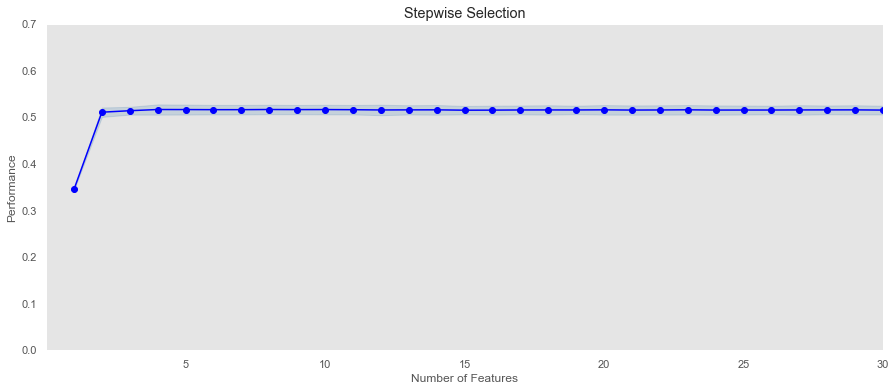

In [45]:
# forward selection graph
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .7])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
# plt.savefig('FS_fdr.png')
plt.show()

In [46]:
# show the feature selection result
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS.head()
#vars_FS.to_csv('VarsFS.csv', index=False)

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.344219010561423, 0.346394330971238]",0.345307,"(fulladdress_count_30,)",0.00468,0.001088,0.001088
2,"(3, 79)","[0.5009727626459144, 0.5210504376823677]",0.511012,"(fulladdress_count_30, ssn_dob_count_30)",0.043194,0.010039,0.010039
3,"(3, 10, 79)","[0.5058365758754864, 0.5225788522995692]",0.514208,"(fulladdress_count_30, fulladdress_unique_coun...",0.036018,0.008371,0.008371
4,"(3, 4, 10, 79)","[0.5058365758754864, 0.527719883284702]",0.516778,"(fulladdress_count_30, address_count_14, fulla...",0.047078,0.010942,0.010942
5,"(3, 4, 10, 12, 79)","[0.5059755419677598, 0.5273030429345561]",0.516639,"(fulladdress_count_30, address_count_14, fulla...",0.045882,0.010664,0.010664


In [47]:
# show the top 30 features
vars_final = list(vars_FS.loc[num_wrapper, 'feature_names'])
vars_final.append('index_name')
vars_final.append(y_name)
vars_final

['fulladdress_count_30',
 'address_count_14',
 'fulladdress_count_14',
 'address_count_7',
 'address_count_0_by_30',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_zip5_60',
 'fulladdress_unique_count_for_ssn_fulladdress_60',
 'fulladdress_unique_count_for_name_fulladdress_60',
 'address_count_0_by_14',
 'fulladdress_unique_count_for_ssn_zip5_30',
 'fulladdress_count_3',
 'fulladdress_unique_count_for_fulladdress_dob_30',
 'fulladdress_unique_count_for_ssn_name_14',
 'fulladdress_unique_count_for_ssn_14',
 'fulladdress_unique_count_for_ssn_name_dob_14',
 'fulladdress_unique_count_for_dob_homephone_7',
 'fulladdress_unique_count_for_ssn_zip5_7',
 'fulladdress_unique_count_for_fulladdress_dob_7',
 'fulladdress_unique_count_for_name_fulladdress_7',
 'fulladdress_unique_count_for_dob_homephone_3',
 'fulladdress_unique_count_for_ssn_name_dob_3',
 'fulladdress_unique_count_for_ssn_fulladdress_3',
 'fulladd

In [48]:
# build the dataset for final modeling with 30 features
X_final = df_total.filter(vars_final, axis = 1)
print(X_final.shape)
#X_final.to_csv('vars_final.csv', index=False)

(1000000, 31)


# Model Building and Evaluation

In [49]:
vars = X_final.copy()

In [50]:
# use this to cap variables. For some problems it helps
Clip = 10

In [51]:
# get Y variable
Y_save = pd.DataFrame(vars.loc[:,'fraud_label'])
Y_save.head()

,fraud_label
0,0
1,1
2,0
3,0
4,0


In [52]:
# get X variable before scaling
X_no_scaling = vars.drop(columns = ['fraud_label'])
X_no_scaling.describe()

,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,address_count_0_by_30,fulladdress_unique_count_for_dob_homephone_60,fulladdress_unique_count_for_ssn_lastname_60,fulladdress_unique_count_for_ssn_zip5_60,fulladdress_unique_count_for_ssn_fulladdress_60,fulladdress_unique_count_for_name_fulladdress_60,...,fulladdress_unique_count_for_name_fulladdress_7,fulladdress_unique_count_for_dob_homephone_3,fulladdress_unique_count_for_ssn_name_dob_3,fulladdress_unique_count_for_ssn_fulladdress_3,fulladdress_unique_count_for_fulladdress_dob_3,fulladdress_unique_count_for_name_fulladdress_3,address_count_0_by_7,ssn_dob_count_30,name_dob_count_30,ssn_firstname_count_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.064624,1.054714,1.047969,1.042545,29.359901,1.044485,1.038636,1.038559,1.038559,1.037934,...,1.031652,1.028339,1.028287,1.027970,1.028236,1.027930,6.948009,1.046097,1.046295,1.048903
std,0.633831,0.617950,0.606858,0.585750,3.201461,0.617953,0.613757,0.613686,0.613686,0.612499,...,0.574846,0.539661,0.539618,0.539335,0.539282,0.539298,0.453021,0.496315,0.496914,0.499029
min,1.000000,1.000000,1.000000,1.000000,1.304348,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.318182,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000
max,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,7.000000,34.000000,34.000000,34.000000


In [53]:
# get X variable after scaling
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [54]:
# push in any outlier values
# Sometimes it helps to reduce the span of an independent variable when all the useful information is at one end.
cols = X.columns
X.loc[:,cols] = X[cols].clip(upper=Clip, lower=-1*Clip)
X.describe()

,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,address_count_0_by_30,fulladdress_unique_count_for_dob_homephone_60,fulladdress_unique_count_for_ssn_lastname_60,fulladdress_unique_count_for_ssn_zip5_60,fulladdress_unique_count_for_ssn_fulladdress_60,fulladdress_unique_count_for_name_fulladdress_60,...,fulladdress_unique_count_for_name_fulladdress_7,fulladdress_unique_count_for_dob_homephone_3,fulladdress_unique_count_for_ssn_name_dob_3,fulladdress_unique_count_for_ssn_fulladdress_3,fulladdress_unique_count_for_fulladdress_dob_3,fulladdress_unique_count_for_name_fulladdress_3,address_count_0_by_7,ssn_dob_count_30,name_dob_count_30,ssn_firstname_count_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,-0.018176,-0.018322,-0.018944,-0.018960,7.459644e-14,-0.019380,-0.019730,-0.019736,-0.019736,-0.019776,...,-0.019772,-0.019721,-0.019724,-0.019746,-0.019734,-0.019749,0.004369,-0.017649,-0.017617,-0.017457
std,0.631721,0.619771,0.597081,0.581643,1.000000e+00,0.591268,0.579416,0.579228,0.579228,0.577105,...,0.550731,0.522706,0.522556,0.521583,0.522500,0.521457,0.949171,0.571302,0.572884,0.579481
min,-0.101958,-0.088541,-0.079045,-0.072633,-8.763360e+00,-0.071988,-0.062950,-0.062832,-0.062832,-0.061933,...,-0.055062,-0.052513,-0.052420,-0.051860,-0.052359,-0.051790,-10.000000,-0.092879,-0.093165,-0.097996
25%,-0.101958,-0.088541,-0.079045,-0.072633,1.999398e-01,-0.071988,-0.062950,-0.062832,-0.062832,-0.061933,...,-0.055062,-0.052513,-0.052420,-0.051860,-0.052359,-0.051790,0.114765,-0.092879,-0.093165,-0.097996
50%,-0.101958,-0.088541,-0.079045,-0.072633,1.999398e-01,-0.071988,-0.062950,-0.062832,-0.062832,-0.061933,...,-0.055062,-0.052513,-0.052420,-0.051860,-0.052359,-0.051790,0.114765,-0.092879,-0.093165,-0.097996
75%,-0.101958,-0.088541,-0.079045,-0.072633,1.999398e-01,-0.071988,-0.062950,-0.062832,-0.062832,-0.061933,...,-0.055062,-0.052513,-0.052420,-0.051860,-0.052359,-0.051790,0.114765,-0.092879,-0.093165,-0.097996
max,10.000000,10.000000,10.000000,10.000000,1.999398e-01,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.114765,10.000000,10.000000,10.000000


In [55]:
# separate data into modeling (traintest) and out of time
seperate_line = 600000

X_trntst = X[0:seperate_line]
Y_trntst = Y_save[0:seperate_line]
X_oot = X[seperate_line:]
Y_oot = Y_save[seperate_line:]

In [56]:
# niter = 0
nitermax = 10
FDR3 = pd.DataFrame(columns=('trn', 'tst', 'oot', 'model'))
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

In [57]:
# define the function of running model
def model_run(model, X, Y, m):
    predictions = model.predict_proba(X)[:,1]
    X['predicted'] = predictions
    X['fraud_label'] = Y['fraud_label']
    topRows = int(round(X.shape[0]*0.03))
    temp = X.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'fraud_label']
    FDR3_temp.loc[niter, m] = sum(needed)/sum(X.loc[:,'fraud_label'])

In [58]:
# build models for grid search
model_dict = {}

# change Logistic Regression parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
for para_a in ['l1', 'l2']:
    for para_b in ['saga',  'liblinear']:
        para = str(para_a)+'-'+str(para_b)
        model_dict[('Logistic Regression', para)] = \
        LogisticRegression(penalty = para_a, solver = para_b, max_iter=10)

# change Decision Tree parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
for para_a in ['best', 'random']:
    for para_b in ['gini', 'entropy']:
        para = str(para_a)+'-'+str(para_b)
        model_dict[('Decision Tree', para)] = \
        DecisionTreeClassifier(splitter = para_a, criterion = para_b)

# change Random Forest parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
for para_a in [50, 100]:
    for para_b in ['gini', 'entropy']:
        para = str(para_a)+'-'+str(para_b)
        model_dict[('Random Forest', para)] = \
        RandomForestClassifier(n_estimators = para_a, criterion = para_b)
            
# change LGB parameters
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
for para_a in ['gbdt', 'dart', 'goss']:
    for para_b in [50, 100, 200]:
        para = str(para_a)+'-'+str(para_b)
        model_dict[('LGB', para)] = \
        LGBMClassifier(boosting_type = para_a, n_estimators=para_b, learning_rate = 0.1)

# change MLP parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
for para_a in [ 'tanh', 'relu']:
    for para_b in ['lbfgs', 'adam']:
        para = str(para_a)+'-'+str(para_b)
        model_dict[('MLP', para)] = \
        MLPClassifier(activation = para_a, solver = para_b)

In [59]:
# run the model
for model_name in model_dict.keys():
    print(f'Working on: {model_name} Model')
    try:   
        model = model_dict[model_name]

        # create a temperate dataframe
        FDR3_temp = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))

        for niter in range(nitermax): 
            X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)
            X_oot = X_oot_orig.copy()

            model.fit(X_trn, Y_trn.values.ravel())   
            model_run(model, X_trn, Y_trn, 'trn')
            model_run(model, X_tst, Y_tst, 'tst')
            model_run(model, X_oot, Y_oot, 'oot')
            #print(niter, FDR3_temp.loc[niter, 'trn'], FDR3_temp.loc[niter, 'tst'], FDR3_temp.loc[niter, 'oot'])

        print(FDR3_temp.mean())
        FDR3_temp['model'] = model_name[0]
        FDR3_temp['parameter'] = model_name[1]

        # combine the temperate dataframe with the whole dataframe
        FDR3 = pd.concat([FDR3, FDR3_temp])
        print('-----')
        
    except:
        print(model_name, 'not avaliable')
        print('-----')
    
FDR3 = FDR3[['model', 'parameter', 'trn', 'tst', 'oot']]

Working on: ('Logistic Regression', 'l1-saga') Model
trn    0.498891
tst    0.496901
oot    0.506863
dtype: float64
-----
Working on: ('Logistic Regression', 'l1-liblinear') Model
trn    0.498619
tst    0.499243
oot    0.506659
dtype: float64
-----
Working on: ('Logistic Regression', 'l2-saga') Model
trn    0.498937
tst    0.495371
oot    0.506268
dtype: float64
-----
Working on: ('Logistic Regression', 'l2-liblinear') Model
trn    0.502018
tst    0.505153
oot    0.508663
dtype: float64
-----
Working on: ('Decision Tree', 'best-gini') Model
trn    0.515243
tst    0.501547
oot    0.513368
dtype: float64
-----
Working on: ('Decision Tree', 'best-entropy') Model
trn    0.513542
tst    0.506781
oot    0.513385
dtype: float64
-----
Working on: ('Decision Tree', 'random-gini') Model
trn    0.515695
tst    0.501445
oot    0.511959
dtype: float64
-----
Working on: ('Decision Tree', 'random-entropy') Model
trn    0.516214
tst    0.498869
oot    0.511415
dtype: float64
-----
Working on: ('Random

In [60]:
# show the fraud detection rate at 3% for each model
FDR3

,model,parameter,trn,tst,oot
0,Logistic Regression,l1-saga,0.494620,0.516810,0.509088
1,Logistic Regression,l1-saga,0.508532,0.491689,0.510617
2,Logistic Regression,l1-saga,0.502943,0.498632,0.509088
3,Logistic Regression,l1-saga,0.490080,0.498658,0.502803
4,Logistic Regression,l1-saga,0.489262,0.500000,0.503143
...,...,...,...,...,...
5,MLP,relu-adam,0.515906,0.497856,0.522507
6,MLP,relu-adam,0.517585,0.503472,0.523526
7,MLP,relu-adam,0.515474,0.500801,0.521998
8,MLP,relu-adam,0.507353,0.524187,0.522847


In [61]:
# show the average fraud detection rate at 3% for each model
FDR3.groupby(['model', 'parameter']).mean()

trn       tst       oot
model               parameter                                   
Decision Tree       best-entropy    0.513542  0.506781  0.513385
                    best-gini       0.515243  0.501547  0.513368
                    random-entropy  0.516214  0.498869  0.511415
                    random-gini     0.515695  0.501445  0.511959
LGB                 dart-100        0.514952  0.513151  0.524036
                    dart-200        0.515038  0.510531  0.523917
                    dart-50         0.514409  0.511283  0.523475
                    gbdt-100        0.514970  0.512425  0.523883
                    gbdt-200        0.515326  0.509402  0.523798
                    gbdt-50         0.515662  0.510220  0.523900
                    goss-100        0.514533  0.512733  0.523713
                    goss-200        0.514705  0.512020  0.524138
                    goss-50         0.514555  0.513674  0.523934
Logistic Regression l1-liblinear    0.498619  0.499243  0.506659
                    l1-saga         0.498891  0.496901  0.506863
                    l2-liblinear    0.502018  0.505153  0.508663
                    l2-saga         0.498937  0.495371  0.506268
MLP                 relu-adam       0.514012  0.508729  0.522830
                    relu-lbfgs      0.511836  0.513636  0.521998
                    tanh-adam       0.511634  0.513906  0.522422
                    tanh-lbfgs      0.510489  0.510376  0.517921
Random Forest       100-entropy     0.513373  0.517591  0.523000
                    100-gini        0.514769  0.511713  0.522864
                    50-entropy      0.516235  0.507892  0.522524
                    50-gini         0.516575  0.508249  0.522541

In [62]:
print('time to here:', datetime.now() - start_time)

time to here: 1:26:28.497429


From the above model result, we can see that the fraud detection rate at 3% is about 52%, which means using this method can detect about 52% of the application fraud with only 3% of the application observations.